### ------------------------- Email Marketing Campaign ------------------------------

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

##### Loading the DataSet

In [ ]:
email_df = pd.read_csv("email_table.csv")
opened_df = pd.read_csv("email_opened_table.csv")
clicked_df = pd.read_csv("link_clicked_table.csv")

##### Merging & Preparing the Dataset

In [ ]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

##### Basic Metrics

In [ ]:
total_users = len(email_df)
open_rate = email_df['opened'].mean() * 100
click_rate = email_df['clicked'].mean() * 100

print(f"Total Emails Sent: {total_users}")
print(f"Open Rate: {open_rate:.2f}%")
print(f"Click Rate: {click_rate:.2f}%")

Total Emails Sent: 100000
Open Rate: 10.35%
Click Rate: 2.12%


##### Click-Through Rate (CTR) by Email Text & Personalization

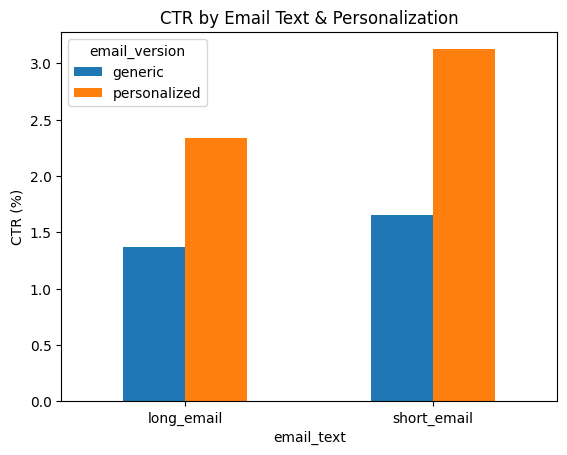

CTR Breakdown:
email_version   generic  personalized
email_text                           
long_email     1.371057      2.340256
short_email    1.657790      3.123106


In [ ]:
text_version_ctr = email_df.groupby(['email_text', 'email_version'])['clicked'].mean().unstack() * 100
text_version_ctr.plot(kind='bar')
plt.title('CTR by Email Text & Personalization')
plt.ylabel('CTR (%)')
plt.xticks(rotation=0)
plt.show()
print("CTR Breakdown:")
print(text_version_ctr)

##### Click-Through Rate (CTR) by Hour

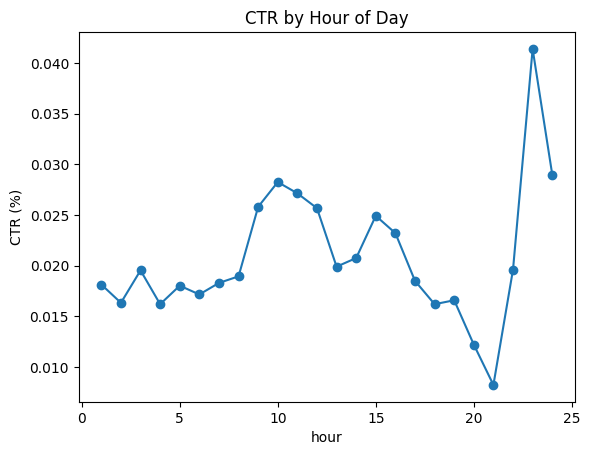

In [17]:
email_df.groupby('hour')['clicked'].mean().plot(marker='o')
plt.title('CTR by Hour of Day')
plt.ylabel('CTR (%)')
plt.show()

##### Click-Through Rate (CTR) by Week_days

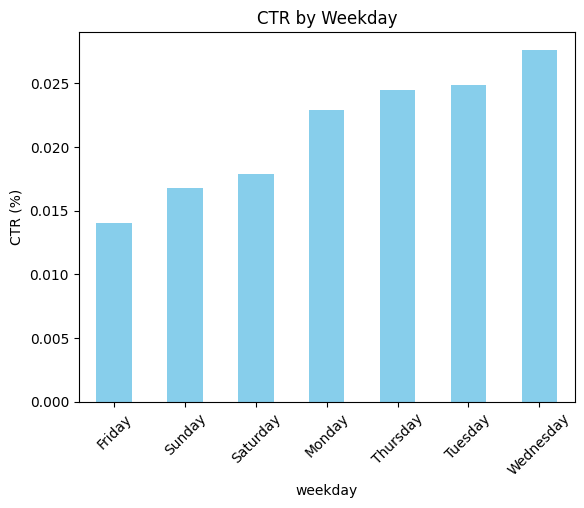

In [16]:
email_df.groupby('weekday')['clicked'].mean().sort_values().plot(kind='bar', color='skyblue')
plt.title('CTR by Weekday')
plt.ylabel('CTR (%)')
plt.xticks(rotation=45)
plt.show()

##### Country level analysis and getting the top 10 countries by Click-Through Rate (CTR)

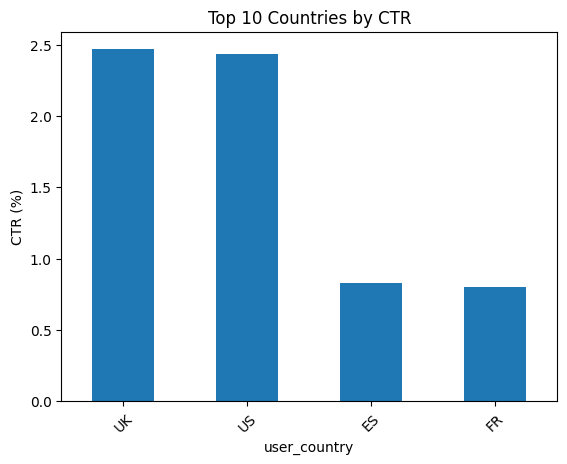

In [18]:
country_ctr = email_df.groupby('user_country')['clicked'].mean().sort_values(ascending=False) * 100
top_countries = country_ctr.head(10)
top_countries.plot(kind='bar')
plt.title('Top 10 Countries by CTR')
plt.ylabel('CTR (%)')
plt.xticks(rotation=45)
plt.show()

##### User Past Purchases & Click-Through Rate (CTR)

Avg Purchases (All): 3.88
Avg Purchases (Clicked): 6.17


C:\Users\deepe\AppData\Local\Temp\ipykernel_27448\777410566.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  email_df.groupby('purchase_bin')['clicked'].mean().plot(kind='bar', color='orange')


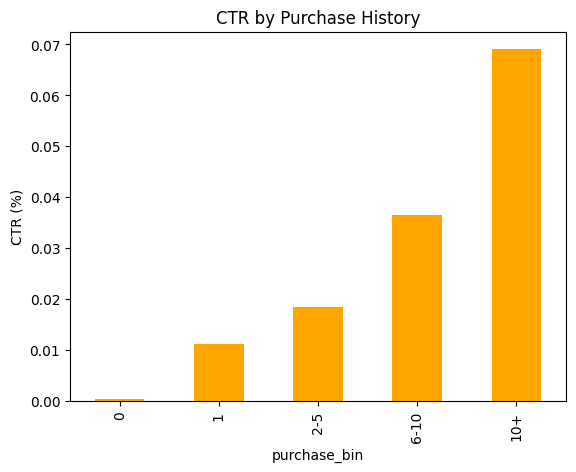

In [19]:
avg_all = email_df['user_past_purchases'].mean()
avg_clicked = email_df[email_df['clicked']==1]['user_past_purchases'].mean()
print(f"Avg Purchases (All): {avg_all:.2f}")
print(f"Avg Purchases (Clicked): {avg_clicked:.2f}")

# Binned CTR
bins = [-1, 0, 1, 5, 10, 100]
labels = ['0', '1', '2-5', '6-10', '10+']
email_df['purchase_bin'] = pd.cut(email_df['user_past_purchases'], bins=bins, labels=labels)
email_df.groupby('purchase_bin')['clicked'].mean().plot(kind='bar', color='orange')
plt.title('CTR by Purchase History')
plt.ylabel('CTR (%)')
plt.show()

##### Open vs Click Rate Correlation

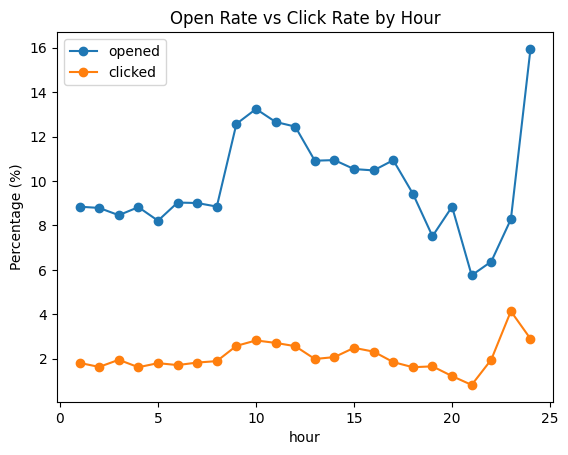

Click-to-Open Rate: 20.00%


In [22]:
open_click = email_df.groupby('hour')[['opened', 'clicked']].mean() * 100
open_click.plot(marker='o')
plt.title('Open Rate vs Click Rate by Hour')
plt.ylabel('Percentage (%)')
plt.show()

opened_and_clicked = email_df[email_df['opened'] == 1]['clicked'].mean() * 100
print(f"Click-to-Open Rate: {opened_and_clicked:.2f}%")

##### Doing the Funnel Analysis

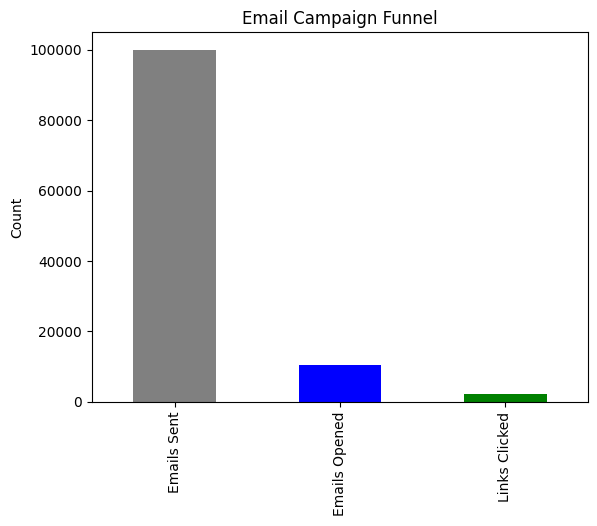

Open Rate: 10.35%
Click Rate: 2.12%
Click-to-Open Rate: 20.48%


In [23]:
sent = len(email_df)
opened = email_df['opened'].sum()
clicked = email_df['clicked'].sum()

funnel = pd.Series({
    'Emails Sent': sent,
    'Emails Opened': opened,
    'Links Clicked': clicked
})

funnel.plot(kind='bar', color=['gray', 'blue', 'green'])
plt.title('Email Campaign Funnel')
plt.ylabel('Count')
plt.show()

print(f"Open Rate: {opened/sent*100:.2f}%")
print(f"Click Rate: {clicked/sent*100:.2f}%")
print(f"Click-to-Open Rate: {clicked/opened*100:.2f}%")

##### Predictive Modeling (Click Prediction)

In [ ]:
X = email_df[['hour', 'user_past_purchases']]
X = pd.get_dummies(email_df[['hour', 'user_past_purchases', 'weekday', 'email_text', 'email_version', 'user_country']], drop_first=True)
y = email_df['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.08      0.01      0.02       453

    accuracy                           0.97     20000
   macro avg       0.53      0.50      0.50     20000
weighted avg       0.96      0.97      0.97     20000

Accuracy: 0.9746


##### Getting the top 10 important features

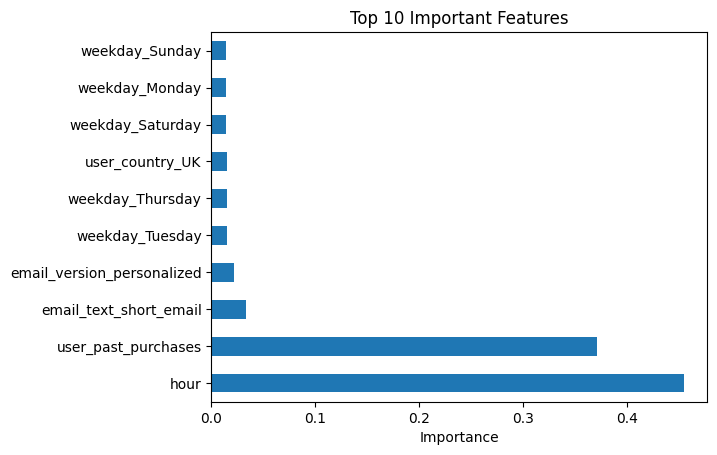

In [24]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
importances.plot(kind='barh')
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.show()


##### Click-Through-Rate (CTR) Uplift Estimation

In [20]:
y_probs = model.predict_proba(X_test)[:, 1]

results_df = X_test.copy()
results_df['actual_clicked'] = y_test.values
results_df['predicted_prob'] = y_probs

top_n_pct = 0.3
top_n = int(len(results_df) * top_n_pct)
targeted_df = results_df.sort_values(by='predicted_prob', ascending=False).head(top_n)

actual_ctr = y_test.mean()
targeted_ctr = targeted_df['actual_clicked'].mean()
estimated_uplift = targeted_ctr - actual_ctr

print(f"🔹 Actual Click-Through Rate (All users): {actual_ctr*100:.2f}%")
print(f"🔹 CTR if Target Top {int(top_n_pct*100)}% (Model-based): {targeted_ctr*100:.2f}%")
print(f"🚀 Estimated Uplift in CTR: {estimated_uplift*100:.2f}%")

🔹 Actual Click-Through Rate (All users): 2.27%
🔹 CTR if Target Top 30% (Model-based): 3.50%
🚀 Estimated Uplift in CTR: 1.24%


##### Segment-wise Pattern Analysis

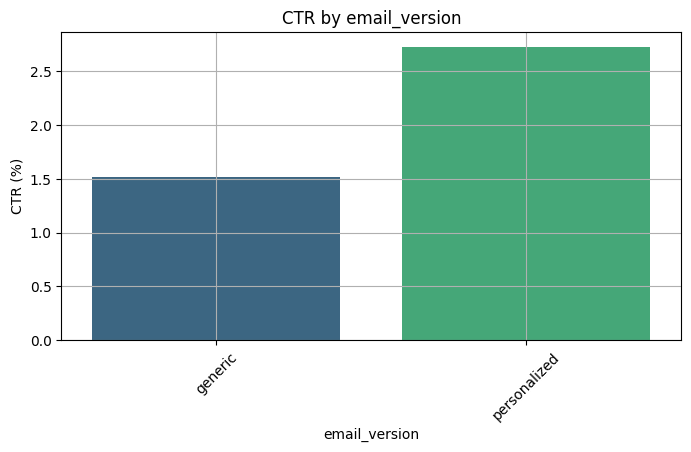


email_version wise CTR:
email_version
personalized    2.729409
generic         1.513673
Name: clicked, dtype: float64



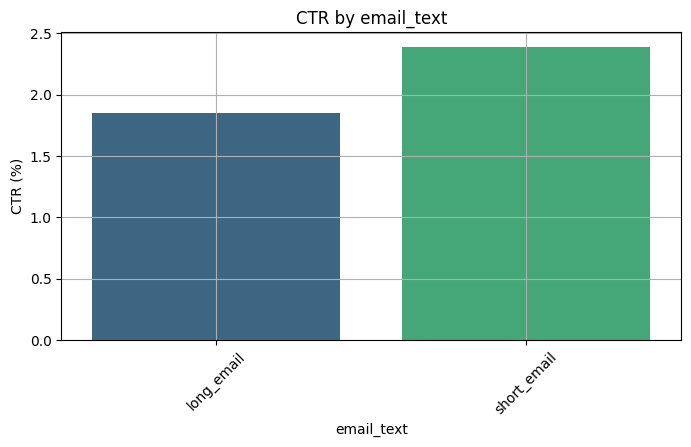


email_text wise CTR:
email_text
short_email    2.387177
long_email     1.853767
Name: clicked, dtype: float64



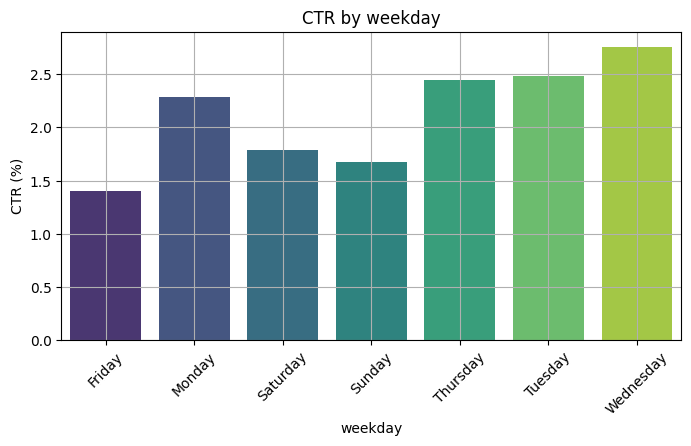


weekday wise CTR:
weekday
Wednesday    2.761999
Tuesday      2.488864
Thursday     2.444491
Monday       2.290608
Saturday     1.784611
Sunday       1.675123
Friday       1.403682
Name: clicked, dtype: float64



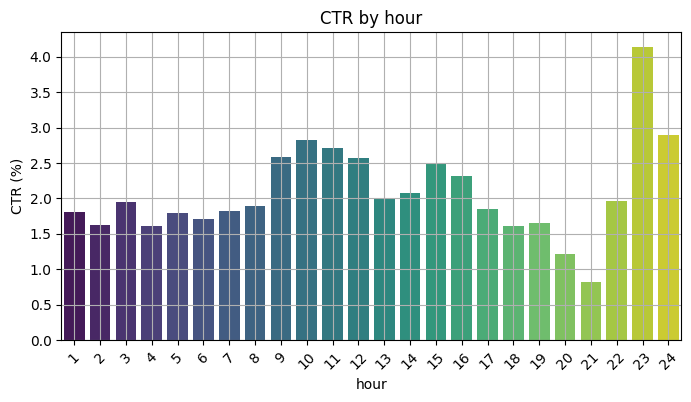


hour wise CTR:
hour
23    4.137931
24    2.898551
10    2.823961
11    2.712816
9     2.579435
12    2.566073
15    2.490696
16    2.319681
14    2.074236
13    1.988891
22    1.960784
3     1.952278
8     1.893308
17    1.848917
7     1.828376
1     1.812801
5     1.801252
6     1.714668
19    1.657459
2     1.632209
4     1.618641
18    1.618578
20    1.219512
21    0.821918
Name: clicked, dtype: float64



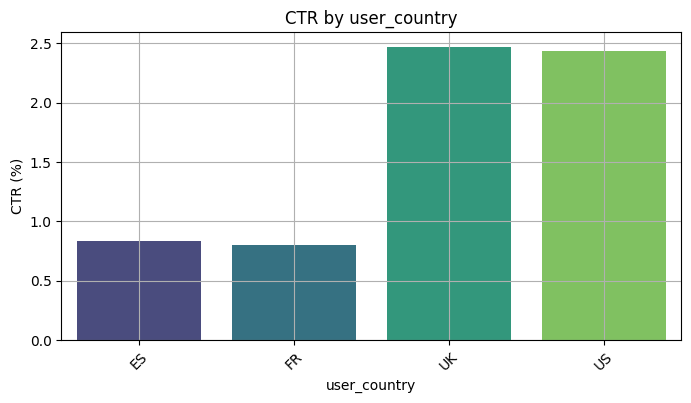


user_country wise CTR:
user_country
UK    2.467526
US    2.435981
ES    0.832748
FR    0.800400
Name: clicked, dtype: float64



C:\Users\deepe\AppData\Local\Temp\ipykernel_27448\890639104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctr = email_df.groupby(feature)['clicked'].mean() * 100
c:\Users\deepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


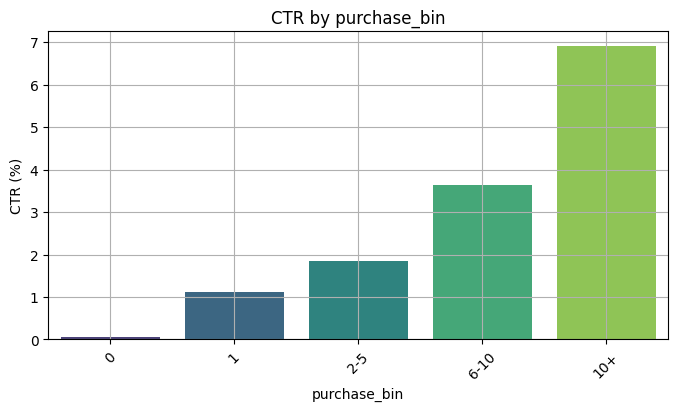


purchase_bin wise CTR:
purchase_bin
10+     6.903711
6-10    3.645062
2-5     1.850862
1       1.119919
0       0.050443
Name: clicked, dtype: float64



In [21]:
def plot_ctr_by(feature):
    ctr = email_df.groupby(feature)['clicked'].mean() * 100
    plt.figure(figsize=(8, 4))
    sns.barplot(x=ctr.index, y=ctr.values, palette='viridis')
    plt.title(f'CTR by {feature}')
    plt.ylabel('CTR (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    print(f"\n{feature} wise CTR:\n{ctr.sort_values(ascending=False)}\n")

plot_ctr_by('email_version')
plot_ctr_by('email_text')
plot_ctr_by('weekday')
plot_ctr_by('hour')
plot_ctr_by('user_country')
plot_ctr_by('purchase_bin')